# https://www.kaggle.com/code/iogbonna/classification-of-ag-news-with-rnn-in-pytorch
# https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset/code?datasetId=612351&sortBy=voteCount&searchQuery=RNN
# https://www.kaggle.com/code/nikenamelia/news-classification-rnn-cnn-eda-deep-cleansing#Model
# https://www.kaggle.com/code/vineetvermaai/ag-news-classification-lstm-gru-accuracy-91-96#MODEL
# https://www.kaggle.com/code/mohsinsial/ag-news-classifications#notebook-container
#

# 1. Библиотеки

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import string
from nltk.corpus import stopwords 
from typing import List, Dict
from tqdm import tqdm
from torch import save
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Проверка наличия GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 2. Чтение данных

In [3]:
train = pd.read_csv("train.csv", encoding = 'latin')
test = pd.read_csv("test.csv", encoding = "latin")

colms = ["Class Index", "Title", "Description"]
train.columns = colms
test.columns = colms

train.info()
print("\n")
test.info()


classes = ['World', 'Sports', 'Business', 'Sci/Tech']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  7600 non-null   int64 
 1   Title        7600 non-null   object
 2   Description  7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.2+ KB


In [67]:
train.head(2)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...


In [3]:
train["Class Index"].value_counts()

Class Index
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64

# 3. Предобработка

In [4]:
train_df = train
test_df = test

In [5]:
def combine_text(row):
    return f"{row['Title']} - {row['Description']}"

train_df['Text'] = train_df.apply(combine_text, axis=1)
test_df['Text'] = test_df.apply(combine_text, axis=1)


# train_df['Text'] = train_df["Description"]
# test_df['Text'] = test_df["Description"]
train_df.head(5)

,Class Index,Title,Description,Text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


In [6]:
# Шаг 1: Очистка текста

STOPWORDS = set(stopwords.words('english'))

english_punctuations = string.punctuation
punctuations_list = english_punctuations

def clean_text(text):
    
    text =  re.sub(r'(.)\1+', r'\1', text)

    text =  re.sub(r'@[^\s]+', ' ', text)

    text =  re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))',' ', text)

    text =  re.sub(r'[0-9]+', '', text)

    # Удаление HTML-тегов
    text = re.sub(r'<.*?>', '', text)
    # Удаление ссылок
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])
    
    translator = str.maketrans('', '', punctuations_list)
    text = text.translate(translator)
    
    return text

def clean_text(text):
    
    # Удаление HTML-тегов
    text = re.sub(r'<.*?>', '', text)
    # Удаление ссылок
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    
    return text


# Пример очистки текста
train_df['Text'] = train_df['Text'].apply(clean_text)
test_df['Text'] = test_df['Text'].apply(clean_text)

In [7]:
class NewsDataset(Dataset):
  def __init__(self,df):
    self.n_samples = len(df)
    self.dataframe = df

  def __getitem__(self, index):
    row = self.dataframe.iloc[index]
    return row['Class Index'], row['Text']

  def __len__(self):
    return self.n_samples

In [8]:
# now we convert the dataframe for the training and testing into datasets
train_dataset = NewsDataset(train_df)
test_dataset = NewsDataset(test_df)

In [ ]:
# !pip install torchtext==0.5.0

     -------------------------------------- 73.2/73.2 kB 669.4 kB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import torch
from torchtext.data.utils import get_tokenizer
import collections
import torchtext
from torch.utils.data import Dataset, DataLoader
import pandas as pd

tokenizer = get_tokenizer('basic_english')

In [10]:
counter = collections.Counter()
for (label, line) in train_dataset:
    counter.update(torchtext.data.utils.ngrams_iterator(tokenizer(line), ngrams=1))
vocab = torchtext.vocab.Vocab(counter, min_freq=1)

In [11]:
vocab_size = len(vocab)
print(f"Vocab size if {vocab_size}")

def encode(x):
    return [vocab.stoi[s] for s in tokenizer(x)]

def decode(x):
    return [vocab.itos[i] for i in x]

Vocab size if 95131


In [12]:
def padify(b):
    v = [encode(x[1]) for x in b]
    l = max(map(len,v))
    return ( # tuple of two tensors - labels and features
        torch.LongTensor([t[0]-1 for t in b]),
        torch.stack([torch.nn.functional.pad(torch.tensor(t),(0,l-len(t)),mode='constant',value=0) for t in v])
    )

In [13]:
class RNNClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self.rnn = torch.nn.RNN(embed_dim,hidden_dim,batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, num_class)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.embedding(x)
        x,h = self.rnn(x)
        return self.fc(x.mean(dim=1))
    
class RNNWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class):
        super(RNNWithAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # Эмбеддинг
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)  # Рекуррентный слой RNN
        self.attention = nn.Linear(hidden_dim, 1)  # Слой внимания (Attention)
        self.fc = nn.Linear(hidden_dim, num_class)  # Полносвязный слой для классификации
        
    def forward(self, x):
        x = self.embedding(x)  # Применяем эмбеддинг
        rnn_out, h = self.rnn(x)  # Проходим через RNN
        attention_weights = torch.softmax(self.attention(rnn_out), dim=1)  # Применяем механизм внимания
        context_vector = torch.sum(attention_weights * rnn_out, dim=1)  # Получаем контекст вектор (взвешенное суммирование)
        output = self.fc(context_vector)  # Применяем полносвязный слой
        
        return output
    

class RNNClassifierWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class):
        super(RNNClassifierWithAttention, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Эмбеддинг
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)  # LSTM для обработки последовательностей
        self.attention = nn.Linear(hidden_dim, 1)  # Слой внимания
        self.fc = nn.Linear(hidden_dim, num_class)  # Полносвязный слой для классификации

        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = self.embedding(x)  # Эмбеддинг
        rnn_out, (hidden, cell) = self.rnn(x)  # Проходим через LSTM
        # Применяем внимание
        attention_scores = torch.tanh(self.attention(rnn_out))        # [batch_size, seq_len, 1]  
        attention_weights = torch.softmax(attention_scores, dim=1)    # [batch_size, seq_len, 1]
        
        # Получаем контекстный вектор, взвешивая выходы RNN
        context_vector = torch.sum(attention_weights * rnn_out, dim=1)  # [batch_size, hidden_dim]
        
        # Применяем полносвязный слой для классификации
        output = self.fc(context_vector)  # [batch_size, num_class]
        
        return output


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, collate_fn=padify, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
model = RNNClassifierWithAttention(vocab_size, embedding_dim=64, hidden_dim=32, num_class=4).to(device)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {trainable_params}")

Number of parameters: 6101093


# 6. Training

Epoch [1/3], Loss: 0.3928, Accuracy: 85.71%


Epoch [2/3], Loss: 0.1947, Accuracy: 93.36%


Epoch [3/3], Loss: 0.1271, Accuracy: 95.64%
Training complete.


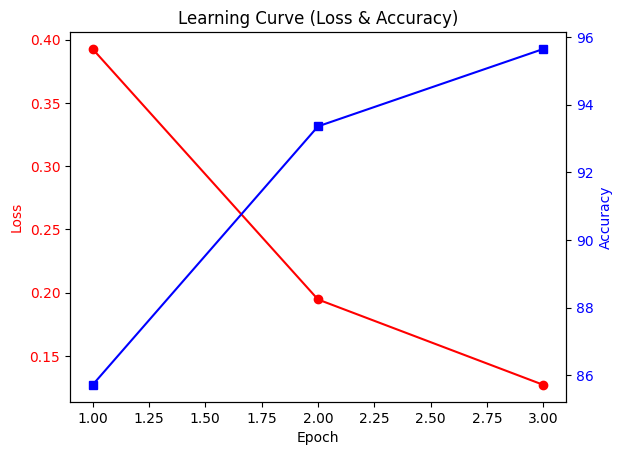

In [27]:
# model = RNNClassifier(vocab_size, 64, 32, 4).to(device)
# model = RNNWithAttention(vocab_size, 64, 32, 4).to(device)

model = RNNClassifierWithAttention(vocab_size, 128, 256, 4).to(device)  

num_epochs = 3
batch_size = 64
lr = 0.001
report_freq=200

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
criterion = criterion.to(device)



train_losses = []
train_accuracies = []


def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.to(device)  # Переносим модель на устройство (CPU/GPU)

    for epoch in range(num_epochs):
        model.train()  # Устанавливаем режим обучения
        total_loss = 0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        
        for labels, inputs in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Обнуляем градиенты
            
            outputs = model(inputs)  # Прямой проход
            loss = criterion(outputs, labels)  # Вычисление функции потерь
            
            loss.backward()  # Обратное распространение
            optimizer.step()  # Обновление весов
            
            total_loss += loss.item()

            # Расчет accuracy
            _, predicted = torch.max(outputs, 1)  # Получаем предсказанные классы
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            acc = correct / total  # Текущая точность
            progress_bar.set_postfix(loss=loss.item(), accuracy=acc * 100)

        avg_loss = total_loss / len(train_loader)
        final_acc = correct / total * 100

        train_losses.append(avg_loss)
        train_accuracies.append(final_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {final_acc:.2f}%")

    print("Training complete.")


# Запуск обучения
train_model(model, train_loader, criterion, optimizer, num_epochs, device)

from torch import save
save(model.state_dict(), "rnn_attention_TORCH.pth")


# Построение графика
epochs = range(1, num_epochs + 1)
fig, ax1 = plt.subplots()

ax1.plot(epochs, train_losses, 'ro-', label='Loss')  # Красная линия - Loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(epochs, train_accuracies, 'bs-', label='Accuracy')  # Синяя линия - Accuracy
ax2.set_ylabel('Accuracy', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title("Learning Curve (Loss & Accuracy)")
plt.show()

# 7. Оценка модели

In [28]:
def test_model_with_accuracy(model, test_loader, vocab, classes, device):
    model.eval()  # Переводим модель в режим оценки (без градиентов)
    
    correct = 0  # Количество правильных предсказаний
    total = 0  # Общее количество примеров
    with torch.no_grad():  # Не вычисляем градиенты во время тестирования
        for batch_idx, (target, data) in enumerate(test_loader):
            
            # Перенос данных и меток на устройство
            data, target = data.to(device), target.to(device)
            
            # Получение предсказаний
            pred = model(data)
            
            # Вычисляем количество правильных предсказаний
            _, predicted = torch.max(pred, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        # Вычисление точности
        accuracy = 100 * correct / total
        print(f"Accuracy of the model on the test data: {accuracy:.2f}%")




test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, collate_fn=padify, shuffle=True)

# Загрузка модели (определите вашу архитектуру перед загрузкой)
model = RNNClassifierWithAttention(vocab_size, 128, 256, 4).to(device)  
# model = RNNClassifier(vocab_size, 64, 32, 4).to(device)  # 90_75
model.load_state_dict(torch.load("rnn_attention_TORCH.pth"))

# model.load_state_dict(torch.load("models/final/RNN + Attetion_final.pth"))
model.eval()  # Устанавливаем модель в режим оценки
model.to(device)


# Получаем прогнозы и истинные метки
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        labels, text = batch
        text, labels = text.to(device), labels.to(device)

        # Получаем выходы модели
        outputs = model(text)
        predicted_classes = torch.argmax(outputs, dim=1)

        all_preds.extend(predicted_classes.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Создаем отчет классификации
report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
print(report)

# test_model_with_accuracy(model, test_loader, vocab, classes, device)

C:\Users\Alex\AppData\Local\Temp\ipykernel_1588\1056794695.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("rnn_attention_TORCH.pth"))


              precision    recall  f1-score   support

       World     0.9365    0.9011    0.9185      1900
      Sports     0.9458    0.9821    0.9636      1900
    Business     0.9011    0.8679    0.8842      1900
    Sci/Tech     0.8740    0.9058    0.8896      1900

    accuracy                         0.9142      7600
   macro avg     0.9144    0.9142    0.9140      7600
weighted avg     0.9144    0.9142    0.9140      7600



              precision    recall  f1-score   support

       World     0.9387    0.9026    0.9203      1900
      Sports     0.9459    0.9837    0.9644      1900
    Business     0.9027    0.8695    0.8858      1900
    Sci/Tech     0.8770    0.9079    0.8922      1900

    accuracy                         0.9159      7600
   macro avg     0.9161    0.9159    0.9157      7600
weighted avg     0.9161    0.9159    0.9157      7600



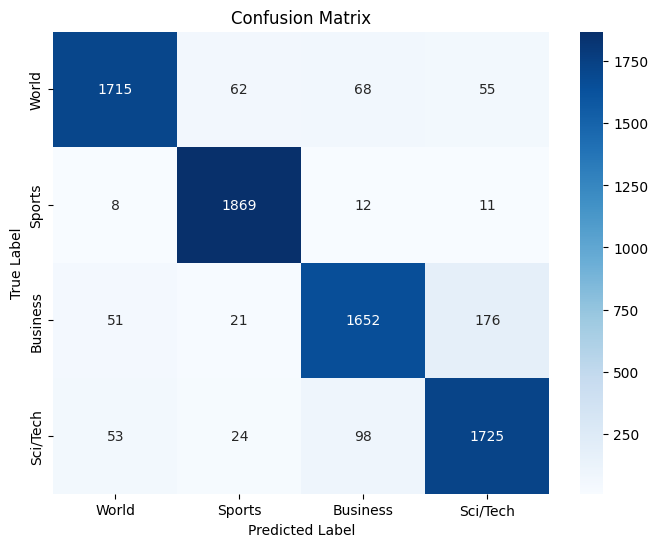

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Получаем прогнозы и истинные метки
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        labels, text = batch
        text, labels = text.to(device), labels.to(device)

        # Получаем выходы модели
        outputs = model(text)
        predicted_classes = torch.argmax(outputs, dim=1)

        all_preds.extend(predicted_classes.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Создаем отчет классификации
report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
print(report)

# Создаем и отображаем матрицу ошибок
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


odel.load_state_dict(torch.load("rnn_attention_TORCH.pth"))
              precision    recall  f1-score   support

       World     0.9259    0.9279    0.9269      1900
      Sports     0.9647    0.9795    0.9721      1900
    Business     0.8961    0.8758    0.8858      1900
    Sci/Tech     0.8969    0.9016    0.8992      1900

    accuracy                         0.9212      7600
   macro avg     0.9209    0.9212    0.9210      7600
weighted avg     0.9209    0.9212    0.9210      7600

In [ ]:
import itertools
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from tqdm import tqdm  # Добавляем tqdm для прогресса

# Гиперпараметры для подбора
param_grid = {
    "embed_size": [64, 128],
    "hidden_size": [128, 256],
    "rnn_type": ["GRU", "LSTM"],
    "num_layers": [1, 2],  
    "dropout": [0.0, 0.2],  
    "learning_rate": [0.001, 0.0005],
    "batch_size": [32, 64],
    "optimizer": ["Adam", "SGD"],  
    "activation": ["ReLU", "Tanh"]
}

# Генерируем все комбинации параметров
param_combinations = list(itertools.product(*param_grid.values()))

# Список для сохранения результатов
results = []

# Функция создания модели
def create_model(vocab_size, embed_size, hidden_size, rnn_type, num_layers, dropout, activation, num_classes=4):
    class AttentionRNN(nn.Module):
        def __init__(self):
            super(AttentionRNN, self).__init__()
            self.embedding = nn.Embedding(vocab_size, embed_size)
            rnn_class = nn.GRU if rnn_type == "GRU" else nn.LSTM
            self.rnn = rnn_class(embed_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
            self.attention = nn.Linear(hidden_size, 1)
            self.fc = nn.Linear(hidden_size, num_classes)
            self.activation = nn.ReLU() if activation == "ReLU" else nn.Tanh()

        def forward(self, x):
            embed = self.embedding(x)
            rnn_out, _ = self.rnn(embed)
            attn_weights = torch.softmax(self.attention(rnn_out), dim=1)
            attn_out = torch.sum(rnn_out * attn_weights, dim=1)
            return self.fc(self.activation(attn_out))

    return AttentionRNN()

# Запуск обучения для всех комбинаций
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for params in tqdm(param_combinations, desc="Гиперпараметрический поиск"):
    embed_size, hidden_size, rnn_type, num_layers, dropout, learning_rate, batch_size, optimizer_name, activation = params
    
    # Создание DataLoader с новым batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Создание модели
    model = create_model(len(vocab) + 1, embed_size, hidden_size, rnn_type, num_layers, dropout, activation).to(device)

    # Выбор оптимизатора
    optimizer = {
        "Adam": optim.Adam(model.parameters(), lr=learning_rate),
        "SGD": optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    }[optimizer_name]

    criterion = nn.CrossEntropyLoss()

    # Обучение
    start_time = time.time()
    for epoch in tqdm(range(5), desc="Обучение", leave=False):  # Добавляем tqdm для отслеживания эпох
        model.train()
        total_loss = 0
        for X_batch, Y_batch in tqdm(train_loader, desc="Batch обработка", leave=False):
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    
    # Оценка модели
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == Y_batch).sum().item()
            total += Y_batch.size(0)

    accuracy = correct / total * 100
    train_time = time.time() - start_time

    # Сохранение результатов
    result_entry = {
        "embed_size": embed_size,
        "hidden_size": hidden_size,
        "rnn_type": rnn_type,
        "num_layers": num_layers,
        "dropout": dropout,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "optimizer": optimizer_name,
        "activation": activation,
        "accuracy": accuracy,
        "train_time_sec": train_time
    }
    results.append(result_entry)

    print(f"Params: {params}, Accuracy: {accuracy:.2f}%, Time: {train_time:.2f}s")

# **Сохранение результатов в CSV**
results_df = pd.DataFrame(results)
results_df.to_csv("results.csv", index=False)

# **Сохранение результатов в TXT**
with open("results.txt", "w") as f:
    for result in results:
        f.write(str(result) + "\n")

print("Готово! Результаты сохранены в results.csv и results.txt")